<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/augmented_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras import backend as K

In [2]:
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'BSc_Project', 'out')
a_dataset = os.path.join(data_dir, 'A')
models_path = os.path.join(base_dir, 'BSc_Project', 'models')

In [3]:
batch_size = 64
img_height = 224
img_width = 224

In [4]:
def load_image(filepath, dims):
   image = cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   image = cv2.resize(image, dims)
   image = image.astype('float32') / 255.0
   return image


def image_arrays_from_directory(directory):
  arrays = []
  counter = 0
  for i, cat in enumerate(os.listdir(directory)):
    path = os.path.join(directory, cat)
    for image in os.listdir(path):
      counter += 1
      image = load_image(os.path.join(path, image), dims=(img_height, img_width))
      arrays.append((image, 1 - i))
  print(f"{counter} images were read")
  return arrays


def train_validation_split(data_array, ratio):
  length = int(ratio * len(data_array))
  return data_array[length:], data_array[:length]

In [5]:
dataset_images = image_arrays_from_directory(a_dataset)
dataset_images[0]

948 images were read


(array([[[0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         ...,
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807],
         [0.12156863, 0.5764706 , 0.54509807]],
 
        [[0.13333334, 0.5372549 , 0.5529412 ],
         [0.13333334, 0.5372549 , 0.5529412 ],
         [0.13333334, 0.5372549 , 0.5529412 ],
         ...,
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336]],
 
        [[0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         [0.11764706, 0.6156863 , 0.53333336],
         ...,
         [0.1254902 , 0.5686275 , 0.54901963],
         [0.1254902 , 0.5686275 , 0.54901963],
         [0.1254902 , 0.5686275 , 0.54901963]],
 
        ...,
 
        [[0.92941177, 0.8980392 , 0.10588235],
         [0.92941177, 0.8980392 , 0.10588

In [6]:
import random
random.seed(123)
random.shuffle(dataset_images)
train, validation = train_validation_split(dataset_images, ratio=0.2)

In [7]:
len(train), len(validation)

(759, 189)

In [8]:
def seperate_lebale(paired_data):
  X = np.array([data for data, label in paired_data])
  y = np.array([label for data, label in paired_data])
  return X, y


X_train, y_train = seperate_lebale(train)
X_valid, y_valid = seperate_lebale(validation)

In [9]:
X_train.shape, y_train.shape

((759, 224, 224, 3), (759,))

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.batch(batch_size, drop_remainder=False).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_dataset.batch(batch_size, drop_remainder=False).cache().prefetch(buffer_size=AUTOTUNE)

####**CNN classification with a VGG-16 model**
First we train the CNN on the unaugmented dataset to obtain the baseline results for comparison to augmented data



In [11]:
tf.random.set_seed(123)
np.random.seed(123)

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(2, activation="softmax"))
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg16_model.fit(train_ds, validation_data=val_ds, epochs=80)

Epoch 1/80
12/12 [==============================] - 44s 2s/step - loss: 0.6938 - accuracy: 0.4941 - val_loss: 0.6919 - val_accuracy: 0.5767
Epoch 2/80
12/12 [==============================] - 11s 903ms/step - loss: 0.6928 - accuracy: 0.5204 - val_loss: 0.6907 - val_accuracy: 0.5767
Epoch 3/80
12/12 [==============================] - 11s 907ms/step - loss: 0.6927 - accuracy: 0.5204 - val_loss: 0.6893 - val_accuracy: 0.5767
Epoch 4/80
12/12 [==============================] - 11s 914ms/step - loss: 0.6925 - accuracy: 0.5204 - val_loss: 0.6880 - val_accuracy: 0.5767
Epoch 5/80
12/12 [==============================] - 11s 927ms/step - loss: 0.6947 - accuracy: 0.5296 - val_loss: 0.6913 - val_accuracy: 0.5344
Epoch 6/80
12/12 [==============================] - 11s 922ms/step - loss: 0.6899 - accuracy: 0.5323 - val_loss: 0.6792 - val_accuracy: 0.6667
Epoch 7/80
12/12 [==============================] - 11s 927ms/step - loss: 0.6536 - accuracy: 0.6535 - val_loss: 0.6186 - val_accuracy: 0.7143
Ep

In [12]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([364, 395]))


### **Classification on VAE augmented dataset**
---


Loading the VAE model

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
def load_autoencoder(names):
  """
  names is a dictionary containing 'decoder' and 'encoder' names
  """
  encoder = keras.models.load_model(os.path.join(models_path, names['encoder']), custom_objects={'Sampling':Sampling}) 
  decoder = keras.models.load_model(os.path.join(models_path, names['decoder']))
  return encoder, decoder 


tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs) 
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(1024, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(1024, activation="relu")(latent_inputs)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder


inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)


inputs = keras.layers.Input(shape=(224, 224, 3))
sch_encoder, sch_codings_log_var, sch_codings_mean = encoder(inputs)
sch_decoder = decoder()
_, _, sch_codings = sch_encoder(inputs)
sch_reconstructions = sch_decoder(sch_codings)
sch_vae = keras.models.Model(inputs=[inputs], outputs=[sch_reconstructions])

sch_latent_loss = -0.5 * K.sum(1 + sch_codings_log_var - K.exp(sch_codings_log_var) - K.square(sch_codings_mean), axis=-1)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 56, 56, 64)   18496       ['conv2d_13[0][0]']              
                                                                                            

In [15]:
norm_encoder, norm_decoder = load_autoencoder({'encoder': 'norm_encoder.h5', 'decoder': 'norm_decoder.h5'})

In [18]:
sch_encoder, sch_decoder = load_autoencoder({'encoder': 'sch_encoder.h5', 'decoder': 'sch_decoder.h5'})

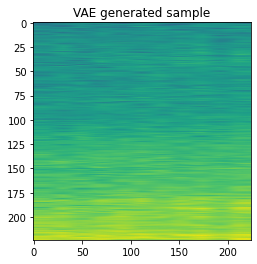

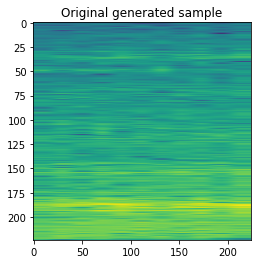

In [21]:
codings = tf.random.normal(shape=[1, latent_dim])
images = sch_decoder(codings).numpy()
plt.title('VAE generated sample')
plt.imshow(np.squeeze(images))
plt.show()

plt.title('Original generated sample')
plt.imshow(X_train[1])
plt.show()

In [22]:
def generate_synth_data(decoder):
  codings = tf.random.normal(shape=[1, latent_dim])
  images = decoder(codings).numpy()
  return np.squeeze(images)

generate_synth_data(norm_decoder).shape

(224, 224, 3)

In [45]:
count = 250
synth_sch = [(generate_synth_data(sch_decoder), 1) for i in range(0, count)]
synth_norm = [(generate_synth_data(norm_decoder), 0) for i in range(0, count)]
synth_dataset = []
synth_dataset.extend(synth_sch)
synth_dataset.extend(synth_norm)

In [46]:
random.shuffle(synth_dataset)
X_syn, y_syn = seperate_lebale(synth_dataset)
print(X_syn.shape, y_syn.shape)

(500, 224, 224, 3) (500,)


In [47]:
X_aug, y_aug = np.concatenate([X_train, X_syn]), np.concatenate([y_train, y_syn])

In [48]:
print(np.unique(y_aug, return_counts=True))
print(X_aug.shape, y_aug.shape)

(array([0, 1]), array([614, 645]))
(1259, 224, 224, 3) (1259,)


In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_aug, y_aug))
train_aug_ds = train_dataset.shuffle(16).batch(batch_size, drop_remainder=False).cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
tf.random.set_seed(123)
np.random.seed(123)

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(2, activation="softmax"))
vgg16_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_63 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_65 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [51]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg16_model.fit(train_aug_ds, validation_data=val_ds, epochs=70)

Epoch 1/70
20/20 [==============================] - 35s 2s/step - loss: 0.6938 - accuracy: 0.5028 - val_loss: 0.6919 - val_accuracy: 0.5767
Epoch 2/70
20/20 [==============================] - 27s 1s/step - loss: 0.6930 - accuracy: 0.5123 - val_loss: 0.6911 - val_accuracy: 0.5767
Epoch 3/70
20/20 [==============================] - 28s 1s/step - loss: 0.6929 - accuracy: 0.5123 - val_loss: 0.6902 - val_accuracy: 0.5767
Epoch 4/70
20/20 [==============================] - 28s 1s/step - loss: 0.6838 - accuracy: 0.5655 - val_loss: 0.6203 - val_accuracy: 0.6349
Epoch 5/70
20/20 [==============================] - 29s 1s/step - loss: 0.4416 - accuracy: 0.7855 - val_loss: 0.3798 - val_accuracy: 0.8413
Epoch 6/70
20/20 [==============================] - 28s 1s/step - loss: 0.2392 - accuracy: 0.9166 - val_loss: 0.6634 - val_accuracy: 0.8148
Epoch 7/70
20/20 [==============================] - 29s 1s/step - loss: 0.1872 - accuracy: 0.9309 - val_loss: 0.7233 - val_accuracy: 0.8677
Epoch 8/70
20/20 [==

**Augmented Data yields 2% improvements over the normal classification (so far)**

In [52]:
vgg16_model.save(os.path.join(models_path, 'augmented_model.h5'))